In [1]:
import pandas as pd
import numpy as np
import pickle
from tqdm import tqdm
from sklearn.metrics import ndcg_score, roc_auc_score, roc_curve, auc
tqdm.pandas()
import matplotlib.pyplot as plt

In [2]:
size = 'demo'
type_ = 'validation'
amount = 1000
predictions_df_path = f'./files/pickle/predictions_df_{size}_{type_}_{str(amount)}.pkl'
predictions_df = pd.read_pickle(predictions_df_path)
print('Predictions df shape:                      ',predictions_df.shape)

Predictions df shape:                       (1000, 6)


In [3]:
predictions_df.head(2)

,user_id,article_ids_inview,article_ids_clicked,Predicted_read_times,Predicted_tuples_sorted,Predicted_article_ids
0,76658,"[9788239, 9780702, 9553264, 9787499, 6741781, ...",[9783042],"[24.071795, 22.684652, 46.022293, 7.843877, 21...","[(9553264, 46.022293), (9783042, 34.445766), (...","[9553264, 9783042, 9788239, 9780702, 6741781, ..."
1,76658,"[9788521, 9786217, 9553264, 9788361, 9788352, ...",[9788125],"[14.823132, 20.94906, 46.022293, 15.545431, 21...","[(9553264, 46.022293), (6741781, 21.78405), (9...","[9553264, 6741781, 9788352, 9786217, 9788125, ..."


In [4]:
predictions_df['user_id'].value_counts()

user_id
1412107    25
1279122    19
1218901    18
790962     17
1230526    13
           ..
2015664     1
1286303     1
2118743     1
1680426     1
1321771     1
Name: count, Length: 366, dtype: int64

In [5]:
def get_reciprocal_rank(row):
    predicted_item_list = row['Predicted_article_ids']
    clicked_article = row['article_ids_clicked'][0]
    try:
        index = predicted_item_list.index(clicked_article)
        # Return the reciprocal rank
        return 1 / (index + 1)
    except ValueError:
        # If the clicked article is not in the predicted list, return 0
        return 0
    
def calculate_precision(target, predictions):
    tp = predictions.count(target)  # Count true positives
    fp = len(predictions) - tp  # Calculate false positives
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0  # Compute precision
    return precision

def calculate_recall(target, predictions):
    tp = predictions.count(target)  # True Positives: target in predictions
    fn = 1 if tp == 0 else 0  # False Negatives: target not in predictions
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0  # Compute recall
    return recall

In [6]:
predictions_df['MMR_rank'] = predictions_df.progress_apply(get_reciprocal_rank,axis=1)
predictions_df['Precision@10']= predictions_df.progress_apply(lambda row: calculate_precision(row['article_ids_clicked'][0],row['Predicted_article_ids']),axis=1)
predictions_df['Recall@10']= predictions_df.progress_apply(lambda row: calculate_recall(row['article_ids_clicked'][0],row['Predicted_article_ids']),axis=1)
predictions_df.head(2)


100%|██████████| 1000/1000 [00:00<00:00, 19606.51it/s]


,user_id,article_ids_inview,article_ids_clicked,Predicted_read_times,Predicted_tuples_sorted,Predicted_article_ids,MMR_rank,Precision@10,Recall@10
0,76658,"[9788239, 9780702, 9553264, 9787499, 6741781, ...",[9783042],"[24.071795, 22.684652, 46.022293, 7.843877, 21...","[(9553264, 46.022293), (9783042, 34.445766), (...","[9553264, 9783042, 9788239, 9780702, 6741781, ...",0.5,0.166667,1.0
1,76658,"[9788521, 9786217, 9553264, 9788361, 9788352, ...",[9788125],"[14.823132, 20.94906, 46.022293, 15.545431, 21...","[(9553264, 46.022293), (6741781, 21.78405), (9...","[9553264, 6741781, 9788352, 9786217, 9788125, ...",0.2,0.142857,1.0


In [7]:
predictions_df.shape

(1000, 9)

In [8]:
predictions_df[predictions_df['MMR_rank']==0]

,user_id,article_ids_inview,article_ids_clicked,Predicted_read_times,Predicted_tuples_sorted,Predicted_article_ids,MMR_rank,Precision@10,Recall@10
6,1014041,"[9277736, 9782449, 9783754, 9186608, 9279095, ...",[9780373],"[32.984257, 32.673767, 26.284801, 32.579144, 3...","[(9279095, 36.528763), (9784094, 34.105656), (...","[9279095, 9784094, 9277736, 9782449, 9186608, ...",0.0,0.0,0.0
14,1245658,"[9781855, 9142564, 9779653, 9551777, 9781872, ...",[9781855],"[13.212748, 17.778234, 50.14214, 15.735682, 16...","[(9779653, 50.14214), (9781814, 46.225285), (9...","[9779653, 9781814, 9781860, 9781856, 9781621, ...",0.0,0.0,0.0
19,1412107,"[9774527, 9774352, 9779430, 9779956, 9777156]",[9779956],"[29.976114, 36.917404, 33.88977]","[(9774352, 36.917404), (9779430, 33.88977), (9...","[9774352, 9779430, 9774527]",0.0,0.0,0.0
20,1412107,"[9779427, 9776967, 9780019, 9779867, 9779417, ...",[9778971],"[34.502384, 28.374094, 25.98723, 27.37667, 39....","[(9695098, 63.091812), (9779417, 39.07347), (9...","[9695098, 9779417, 9780020, 9779427, 9758734, ...",0.0,0.0,0.0
24,2242311,"[9279095, 9142564, 9695098, 9783752, 9783148, ...",[9783757],"[31.888968, 32.182205, 65.12555, 29.6926, 32.8...","[(9781506, 66.3871), (9695098, 65.12555), (978...","[9781506, 9695098, 9782282, 9780467, 9339920, ...",0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...
967,1275613,"[9777200, 9779370, 9784607, 9784298, 9176912, ...",[9784642],"[100.16741, 81.50845, 67.724106, 110.3738, 71....","[(9782656, 148.98338), (9784298, 110.3738), (9...","[9782656, 9784298, 9782806, 9777200, 9784138, ...",0.0,0.0,0.0
973,1218901,"[8054212, 8514670, 9486080, 9455386, 9784782]",[9784782],"[33.239643, 34.54116, 30.516573, 26.465425]","[(8514670, 34.54116), (8054212, 33.239643), (9...","[8514670, 8054212, 9486080, 9455386]",0.0,0.0,0.0
976,1218901,"[9455386, 8054212, 8514670, 9486080, 9784575, ...",[9784662],"[30.516573, 33.239643, 34.54116, 25.743467, 23...","[(8514670, 34.54116), (8054212, 33.239643), (9...","[8514670, 8054212, 9455386, 9486080, 9784575]",0.0,0.0,0.0
977,1881817,"[9783886, 9780860, 9339920, 9777200, 9783729, ...",[9771113],"[9.703958, 8.930187, 12.271992, 12.789862, 22....","[(9783729, 22.995024), (9777324, 22.195091), (...","[9783729, 9777324, 9783197, 9780968, 9782126, ...",0.0,0.0,0.0


In [9]:
predictions_df_per_user = predictions_df.groupby('user_id')[['MMR_rank', 'Precision@10', 'Recall@10']].mean()

In [10]:
predictions_df_per_user.head(2)

,MMR_rank,Precision@10,Recall@10
user_id,,,
19181,0.244048,0.144742,1.0
22895,0.111111,0.111111,1.0


In [11]:
mrr_10 = predictions_df_per_user['MMR_rank'].mean()
precision_10 = predictions_df_per_user['Precision@10'].mean()
recall_10 = predictions_df_per_user['Recall@10'].mean()
f1_score_10 = (2*precision_10*recall_10)/ (precision_10 + recall_10)

print("MRR@10: ", mrr_10)
print("Precision@10: ", precision_10)
print("Recall@10: ", recall_10)
print("F1_Score@10: ", f1_score_10)

MRR@10:  0.33187449008905495
Precision@10:  0.11979704788110261
Recall@10:  0.8152457620511978
F1_Score@10:  0.20889746341856683


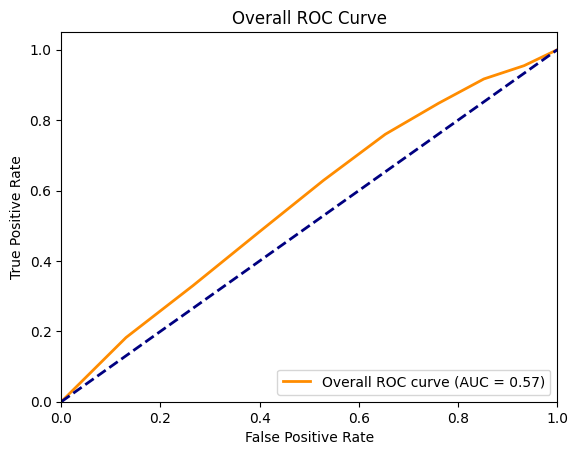

In [13]:
# Function to prepare data for AUC calculation
def prepare_auc_data(df):
    auc_data = []
    for idx, row in df.iterrows():
        clicked_article = row['article_ids_clicked'][0]
        predictions = row['Predicted_article_ids']
        for rank, article in enumerate(predictions, start=1):
            score = 1 / rank  # Higher rank (lower index) gets higher score
            label = 1 if article == clicked_article else 0
            auc_data.append([row['user_id'], article, score, label])
    return pd.DataFrame(auc_data, columns=['user_id', 'article', 'score', 'label'])

# Prepare the data for AUC calculation
auc_df = prepare_auc_data(predictions_df)

# Aggregate data for overall ROC curve
all_labels = auc_df['label']
all_scores = auc_df['score']

# Compute ROC curve and AUC
fpr, tpr, _ = roc_curve(all_labels, all_scores)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange', lw=lw, label=f'Overall ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Overall ROC Curve')
plt.legend(loc="lower right")
plt.show()

Mean AUC: 0.55


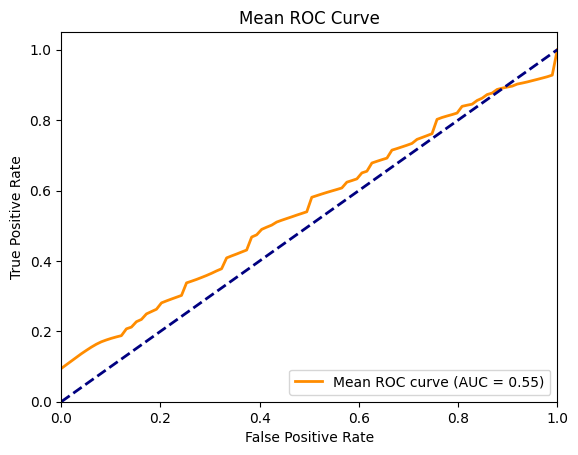

In [14]:
# Function to prepare data for AUC calculation
def prepare_auc_data(df):
    auc_data = []
    for idx, row in df.iterrows():
        clicked_article = row['article_ids_clicked'][0]
        predictions = row['Predicted_article_ids']
        for rank, article in enumerate(predictions, start=1):
            score = 1 / rank  # Higher rank (lower index) gets higher score
            label = 1 if article == clicked_article else 0
            auc_data.append([row['user_id'], article, score, label])
    return pd.DataFrame(auc_data, columns=['user_id', 'article', 'score', 'label'])

# Prepare the data for AUC calculation
auc_df = prepare_auc_data(predictions_df)

# Lists to store AUC, FPR, TPR for each user
auc_scores = []
mean_fpr = np.linspace(0, 1, 100)
tprs = []

# Compute ROC curve for each user
for user_id, group in auc_df.groupby('user_id'):
    labels = group['label'].values  # Ensure labels are in array format
    scores = group['score'].values  # Ensure scores are in array format
    
    # Check for positive samples
    if np.sum(labels) > 0:
        fpr, tpr, _ = roc_curve(labels, scores)
        roc_auc = auc(fpr, tpr)
        auc_scores.append(roc_auc)
        tprs.append(np.interp(mean_fpr, fpr, tpr))  # Interpolate TPR values

# Check if auc_scores is not empty before computing mean_auc
if auc_scores:
    mean_tpr = np.mean(tprs, axis=0)
    mean_auc = np.mean(auc_scores)
    print(f'Mean AUC: {mean_auc:.2f}')

    # Plot mean ROC curve
    plt.figure()
    lw = 2
    plt.plot(mean_fpr, mean_tpr, color='darkorange', lw=lw, label=f'Mean ROC curve (AUC = {mean_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Mean ROC Curve')
    plt.legend(loc="lower right")
    plt.show()
else:
    print('No valid AUC scores found.')

### Interpretation-Document Embeddings

- An MRR of approximately  0.331 means that, on average, the true positive item is found at about the third position in the recommendation list (since 1/0.299≈3.34). This is a reasonably good result, indicating that the recommender system often ranks the relevant items near the top of the recommendation list.

- A Precision@10 of approximately  0.119 means that about 12.8% of the items in the top 10 recommendations are relevant. This indicates that for every 10 items recommended, around 1.28 items are relevant. This precision value suggests that there is room for improvement in terms of recommending more relevant items in the top 10.

- A Recall@10 of 0.815 means that the recommender system successfully identifies 86% of the relevant items within the top 10 recommendations. This high recall value indicates that the system is very effective at finding relevant items, though they may not always be ranked at the very top of the list.

- 0.55

### Interpretation-Dropout

- An MRR of approximately 0.3103 means that, on average, the true positive item is found at about the third position in the recommendation list (since 1/0.299≈3.34). This is a reasonably good result, indicating that the recommender system often ranks the relevant items near the top of the recommendation list.

- A Precision@10 of approximately 0.119 means that about 12.8% of the items in the top 10 recommendations are relevant. This indicates that for every 10 items recommended, around 1.28 items are relevant. This precision value suggests that there is room for improvement in terms of recommending more relevant items in the top 10.

- A Recall@10 of 0.80 means that the recommender system successfully identifies 86% of the relevant items within the top 10 recommendations. This high recall value indicates that the system is very effective at finding relevant items, though they may not always be ranked at the very top of the list.

- AUC 0.57

### Interpretation-OuterJoin

- An MRR of approximately 0.3102 means that, on average, the true positive item is found at about the third position in the recommendation list (since 1/0.299≈3.34). This is a reasonably good result, indicating that the recommender system often ranks the relevant items near the top of the recommendation list.

- A Precision@10 of approximately 0.118 means that about 12.8% of the items in the top 10 recommendations are relevant. This indicates that for every 10 items recommended, around 1.28 items are relevant. This precision value suggests that there is room for improvement in terms of recommending more relevant items in the top 10.

- A Recall@10 of 0.79 means that the recommender system successfully identifies 86% of the relevant items within the top 10 recommendations. This high recall value indicates that the system is very effective at finding relevant items, though they may not always be ranked at the very top of the list.

### Interpretation

- An MRR of approximately 0.299 means that, on average, the true positive item is found at about the third position in the recommendation list (since 1/0.299≈3.34). This is a reasonably good result, indicating that the recommender system often ranks the relevant items near the top of the recommendation list.

- A Precision@10 of approximately 0.128 means that about 12.8% of the items in the top 10 recommendations are relevant. This indicates that for every 10 items recommended, around 1.28 items are relevant. This precision value suggests that there is room for improvement in terms of recommending more relevant items in the top 10.

- A Recall@10 of 0.86 means that the recommender system successfully identifies 86% of the relevant items within the top 10 recommendations. This high recall value indicates that the system is very effective at finding relevant items, though they may not always be ranked at the very top of the list.

### Overall Interpretation
- MRR (0.299): The relevant items are generally ranked around the third position on average.
- Precision@10 (0.128): About 12.8% of the top 10 recommendations are relevant, indicating room for improvement in the quality of top recommendations.
- Recall@10 (0.86): The system successfully finds 86% of the relevant items within the top 10 recommendations, showing strong recall performance.

To improve precision and MRR for your recommender system, you can consider various strategies that involve improving your preprocessing, model, and recommendation logic. Here are some approaches:

1. Data Preprocessing Improvements
    1. Feature Engineering:

        - Add More Features: Incorporate additional features that could influence reading time predictions, such as article length, topic, author, publication date, user preferences, etc.
        - Normalization and Scaling: Ensure that your features are properly normalized and scaled to help the model learn more effectively.
        - Categorical Features: Use techniques like one-hot encoding or embeddings for categorical features (e.g., article categories or authors).

    2. Data Cleaning:

        - Remove Outliers: Identify and remove or handle outliers in reading times to ensure the model isn’t biased by extreme values.
        - Handle Missing Values: Ensure any missing values in the dataset are properly handled through imputation or removal.

    3. Data Augmentation:

        - Synthetic Data: If your dataset is small, consider generating synthetic data to improve model training.

2. Model Improvements

    1. Model Architecture:

        - Experiment with Different Architectures: Try different neural network architectures such as deeper networks, recurrent neural networks (RNNs), transformers, etc.
    - Hyperparameter Tuning: Perform hyperparameter tuning to find the optimal parameters for your model (learning rate, batch size, number of layers, units per layer, etc.).

    2. Training Techniques:

        - Regularization: Use regularization techniques like dropout, L2 regularization, and early stopping to prevent overfitting.
        - Ensemble Methods: Combine predictions from multiple models using ensemble methods (e.g., bagging, boosting) to improve accuracy and robustness.

3. Recommendation Logic Improvements

    1. Post-Processing Predictions:

        - Re-Ranking: After predicting reading times, re-rank articles using additional criteria such as user preferences, recent trends, or article popularity.
        - Hybrid Recommendations:

        - Combine Models: Use a hybrid approach that combines collaborative filtering, content-based filtering, and your read time prediction model to recommend articles.

In [11]:

### Feature engineering
## 1. Outlier Detection - Trained with read time <60 no such improvement 
## 2. Scroll percentage * read time-zero percentage what to do (NaN-not a good idea)- Not improved
## 3. Normalize-scaling 
## 4. Threshold
## 5. Outer join - 
## 6. Check for multiple articles for the same user


### Model Architecture
## 1. Learning Rate
## 2. Early Stopping
## 3. Dropout
## 4. Add more Dense,Layers
## 5. Timestamps-LSTM

### Hybrid Approach
## 1. Contend Based 

### Recommendations
## 1. Apply clustering
## 2. Why we did not get recommends for 2.000 cases 

### Evaluation
## 1.Different Metric-F1

#MAke the right adjustments to make it run all at once

In [20]:
## Tests
#1. Outter join-Scroll percentage-> Not improved-Scrolled percentage not a good feature for the model in our test
#2. Outer join-Worse results
#3. Model Architecture-Dropout
#4. Model Architecture-EarlyStopping
